### Import the Library ###

In [2]:
# inspired by https://www.kaggle.com/nickycan/lb-0-3805009-python-edition
import numpy as np   ## linear algebra
import pandas as pd  ## data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split  ## split train and test
from IPython.display import display ## Allows the use of display() for DataFrames

import matplotlib.pyplot as plt  ## data visualization

import gc   ## clean up 
import time ## time it

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [3]:
class setup_your_clock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))

### Load the Dataset from Feature Engineering ###

In [4]:
## access to hdf5 file
df_data = pd.read_hdf('saved_df_data_whole.h5', 'df_data')

### Train / Test ###

In [5]:
print(df_data.columns)
print(df_data.shape)

Index(['user_id', 'product_id', '_up_order_count', '_up_first_order_number',
       '_up_last_order_number', '_up_average_cart_position', '_prod_tot_cnts',
       '_prod_reorder_tot_cnts', '_prod_buy_first_time_total_cnt',
       '_prod_buy_second_time_total_cnt', '_prod_reorder_prob',
       '_prod_reorder_ratio', '_user_total_orders',
       '_user_sum_days_since_prior_order', '_user_mean_days_since_prior_order',
       '_user_reorder_ratio', '_user_total_products',
       '_user_distinct_products', '_user_average_basket', 'order_id',
       'eval_set', 'time_since_last_order', '_up_order_rate',
       '_up_order_since_last_order', '_up_order_rate_since_first_order',
       'reordered'],
      dtype='object')
(13307953, 26)


### Split the Data ###

In [6]:
df_train = df_data[df_data['eval_set'] == "train"].copy()
df_train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
df_train.loc[:, 'reordered'] = df_train.reordered.fillna(0)

## We can only use X_test for on-line competition submission. 
## X_test = df_data.loc[df_data['eval_set'] == "test"]

X_df_train_raw, X_val_raw, y_df_train_raw, y_val_raw =  train_test_split(df_train.drop('reordered', axis=1), 
                                                        df_train.reordered,
                                                        test_size=0.1, random_state=42)

### Subset Testing Stage ### 

In [30]:
print("-"*10 + " Original size" + "-"*10 )
print(X_df_train_raw.shape)
X_df_train = X_df_train_raw.sample(frac=0.01, random_state=311)
y_df_train = y_df_train_raw.sample(frac=0.01, random_state=311)
print("-"*10 + " Subset size" + "-"*10 )
print(X_df_train.shape)

X_val = X_val_raw.sample(frac=0.01, random_state=311)
y_val = y_val_raw.sample(frac=0.01, random_state=311)

---------- Original size----------
(7627194, 21)
---------- Subset size----------
(76272, 21)


In [31]:
display(X_df_train.head(3))

,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,_prod_reorder_prob,_prod_reorder_ratio,...,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order
6717076,2,6,14,6.0,67283,41585.0,25698,12733,0.495486,0.618061,...,356.0,5.562500,0.823980,802,156,12.338462,3.0,0.030769,51,0.033333
4858197,8,5,71,11.5,17716,8477.0,9239,3525,0.381535,0.478494,...,358.0,4.649351,0.815356,1116,224,14.307692,6.0,0.102564,7,0.108108
9346092,2,2,8,7.0,7642,4756.0,2886,1258,0.435897,0.622350,...,194.0,27.714285,0.409836,138,88,17.250000,24.0,0.250000,0,0.285714


### Normalizing Numerical Features ###  
In practice, the features are normalized so that each feature distribution is treated equally when applying machine learning techniques. It is worth to emphasize that once the scaling is applied, the normalized features cannot be interpreted as the same meaning as the raw data.


In [32]:
## Initialize a scaler, then apply it to the features
## StandardScaler Wrapper
## https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

scaler = StandardScaler()
mapper = DataFrameMapper([(X_df_train.columns, StandardScaler())])
scaled_features = np.round(mapper.fit_transform(X_df_train.copy()), 4)
X_df_train_scaled = pd.DataFrame(scaled_features, index=X_df_train.index, columns=X_df_train.columns)

In [33]:
display(X_df_train_scaled.head(3))
display(y_df_train.head(3))

,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,_prod_reorder_prob,_prod_reorder_ratio,...,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order
6717076,-0.1262,-0.3484,-0.1107,-0.4591,0.8094,0.5806,1.6155,1.2167,0.7212,0.5145,...,1.3541,-1.0986,1.4856,1.6002,0.5373,-0.0493,-1.0943,-0.7530,3.0969,-0.9359
4858197,1.5515,-0.4225,3.1801,0.3309,-0.0857,-0.1647,0.2183,-0.0008,-0.1405,-0.3428,...,1.3728,-1.2398,1.4407,2.6208,1.4092,0.2656,-0.8054,-0.3166,-0.1843,-0.6700
9346092,-0.1262,-0.6446,-0.4571,-0.3155,-0.2676,-0.2484,-0.3211,-0.3005,0.2706,0.5408,...,-0.1640,2.3270,-0.6709,-0.5582,-0.3346,0.7362,0.9284,0.5795,-0.7063,-0.0384


### Join the Table ###

In [35]:
## df_data contains features and target after the merge.
df_data = X_df_train_scaled.join(y_df_train)

features = X_df_train_scaled
##print(features.head(3))
target = y_df_train
##print(target.head(3))

### Check Whether There is Missing Data(NaN) ###

In [38]:
## print(X_df_train.isnull().values.any())
print("True means there is missing data, otherwise no.")
print(df_data.isnull().values.any())

# if df_data.isnull().values.any():
#     nan_rows = df_data[df_data.isnull().any(1)]
# print(len(nan_rows))

True means there is missing data, otherwise no.
False


### Model Evaluation: Quantifying the Quality of Predictions ###  

In [134]:
# Compare Algorithms
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

##import matplotlib.pyplot as plt

In [147]:
## X_train, X_test, y_train, y_test
X = X_df_train_scaled.as_matrix(columns=None)
Y = y_df_train.as_matrix(columns=None)

In [148]:
n_splits_KFOLD = 8

# prepare configuration for cross validation test harness
RANDOM_SEED = 999
seed = 123
# prepare models
models = []
models.append(('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED)))
models.append(('LogisticReg', LogisticRegression(random_state=RANDOM_SEED)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('RandomForest',  RandomForestClassifier(random_state=RANDOM_SEED)))
models.append(('AdaBoost', AdaBoostClassifier(random_state=RANDOM_SEED)))

# evaluate each model in turn
results_all = []
names = []
dict_method_score = {}
scoring = 'f1'

pickle_filename="m2_Methods_Comparison.p"

with open(pickle_filename, "wb") as f:
    print("Method: Average (Standard Deviation)\n")
        for name, model in models:
            pickle.dump(model, f)
            kfold = model_selection.KFold(n_splits=n_splits_KFOLD, random_state=seed)
            cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
            results_all.append(cv_results)
            names.append(name)
            dict_method_score[name] = (cv_results.mean(), cv_results.std())
            print("{:s}: {:.3f} ({:.3f})".format(name, cv_results.mean(), cv_results.std()))

Method: Average (Standard Deviation)

DecisionTree: 0.274 (0.012)
LogisticReg: 0.246 (0.016)
KNN: 0.251 (0.014)
GaussianNB: 0.372 (0.011)
RandomForest: 0.239 (0.018)
AdaBoost: 0.245 (0.019)


In [189]:
print(results_all)

[array([ 0.25510204,  0.29759519,  0.28499749,  0.27480159,  0.27227227,
        0.26498741,  0.26598465,  0.276     ]), array([ 0.23592493,  0.26533997,  0.25404945,  0.23302598,  0.27187766,
        0.22450728,  0.24956672,  0.23509075]), array([ 0.22727273,  0.25753012,  0.259375  ,  0.24756189,  0.27355623,
        0.23041475,  0.25541796,  0.25668449]), array([ 0.35679068,  0.3824667 ,  0.37246249,  0.37942956,  0.37882765,
        0.35904139,  0.36010591,  0.38552115]), array([ 0.22144725,  0.26058632,  0.25560166,  0.23873518,  0.25889968,
        0.24673203,  0.213858  ,  0.21566976]), array([ 0.22669104,  0.25649623,  0.27516779,  0.24625624,  0.26411816,
        0.21428571,  0.24567474,  0.22896791])]


### Load Saved Model ###

In [165]:
models = []
with open(pickle_filename, "rb") as f:
    while True:
        try:
            models.append(pickle.load(f))
        except EOFError:
            break

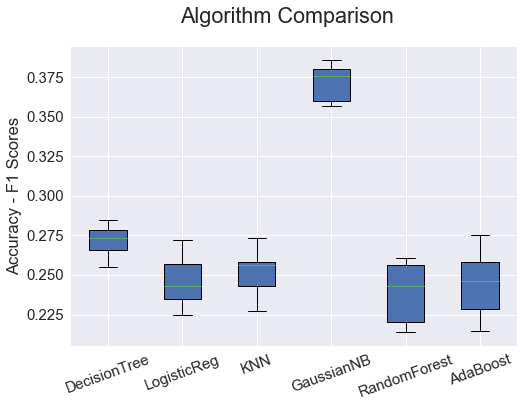

In [183]:
# boxplot algorithm comparison
plt.rc('legend', fontsize=8)    # legend fontsize
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
bplot_1 = plt.boxplot(results_all, patch_artist=True)
plt.xticks(rotation=20)
plt.ylabel('Accuracy - F1 Scores')
ax.set_xticklabels(names)

plt.savefig('./figures/fig_algorithm_compare.png')
plt.show()

### Another Data Visualization ###

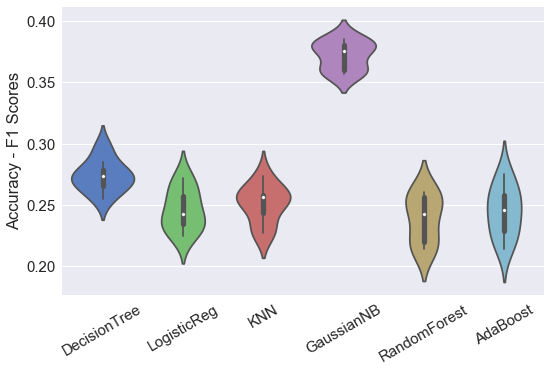

In [188]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
fig = plt.figure()
plt.ylabel('Accuracy - F1 Scores')
ax = sns.violinplot(data=results_all, palette="muted")
fig.get_axes()[0].set_xticklabels(names, rotation=30)
fig.tight_layout()
sns.plt.savefig('./figures/fig_algo_sns.png')

sns.plt.show()
